In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf


In [5]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2010-01-01', end='2020-01-01')['Adj Close']
returns = data.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [6]:
print(data)
print(returns)

Ticker                          AAPL       AMZN       GOOG        MSFT  \
Date                                                                     
2010-01-04 00:00:00+00:00   6.447412   6.695000  15.571998   23.300678   
2010-01-05 00:00:00+00:00   6.458558   6.734500  15.503423   23.308205   
2010-01-06 00:00:00+00:00   6.355827   6.612500  15.112601   23.165163   
2010-01-07 00:00:00+00:00   6.344078   6.500000  14.760787   22.924255   
2010-01-08 00:00:00+00:00   6.386255   6.676000  14.957565   23.082354   
...                              ...        ...        ...         ...   
2019-12-24 00:00:00+00:00  68.898705  89.460503  67.013435  150.531662   
2019-12-26 00:00:00+00:00  70.265694  93.438499  67.853363  151.765549   
2019-12-27 00:00:00+00:00  70.239014  93.489998  67.428902  152.042938   
2019-12-30 00:00:00+00:00  70.655876  92.344498  66.643333  150.732544   
2019-12-31 00:00:00+00:00  71.172119  92.391998  66.687225  150.837784   

Ticker                          TSLA 

In [7]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [8]:
# Mean-Variance Optimization
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std_dev

In [10]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.034):
    p_returns, p_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std_dev

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.034):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [11]:
mean_variance_result = optimize_portfolio(mean_returns, cov_matrix)
weightsMV = mean_variance_result.x

In [12]:
# Black-Litterman Model (Placeholder - Implement based on  assumptions and inputs)
def black_litterman(mean_returns, cov_matrix, P, Q, omega, tau=0.05, risk_free_rate=0.034): # tau is previous market estimate returns 
    # Calculate the equilibrium excess returns
    pi = mean_returns.values
    pi_excess = pi - risk_free_rate
    # Combine with investor views
    M_inverse = np.linalg.inv(tau * cov_matrix + np.dot(np.dot(P.T, np.linalg.inv(omega)), P))
    part1 = np.dot(np.linalg.inv(tau * cov_matrix), pi_excess)
    part2 = np.dot(np.dot(P.T, np.linalg.inv(omega)), Q)
    BL_mean_returns = np.dot(M_inverse, (part1 + part2))
    BL_cov_matrix = cov_matrix + np.linalg.inv(M_inverse)
    return BL_mean_returns, BL_cov_matrix

# Define your views and uncertainties with more views
P = np.array([
    [1, 0, 1, 0, 0],  # View 1: AAPL and GOOG
    [0, 1, 0, 0, 1],  # View 2: MSFT and TSLA
    [1, 1, 0, 0, 0],  # View 3: AAPL and MSFT
    [0, 0, 0, 1, 1],  # View 4: AMZN and TSLA
    [1, 0, 0, 1, 0]   # View 5: AAPL and AMZN
])
Q = np.array([0.05, 0.03, 0.04, 0.02, 0.06])  # Corresponding expected returns for each view
omega = np.diag([0.02, 0.02, 0.02, 0.02, 0.02])  # Uncertainties for each view

BL_mean_returns, BL_cov_matrix = black_litterman(mean_returns, cov_matrix, P, Q, omega)
black_litterman_result = optimize_portfolio(BL_mean_returns, BL_cov_matrix)
weightsBL = black_litterman_result.x

In [13]:
def backtest_portfolio(weights, data, transaction_costs=0.001):
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return cumulative_returns

In [14]:
mean_variance_cumulative_returns = backtest_portfolio(weightsMV, data)
black_litterman_cumulative_returns = backtest_portfolio(weightsBL, data)

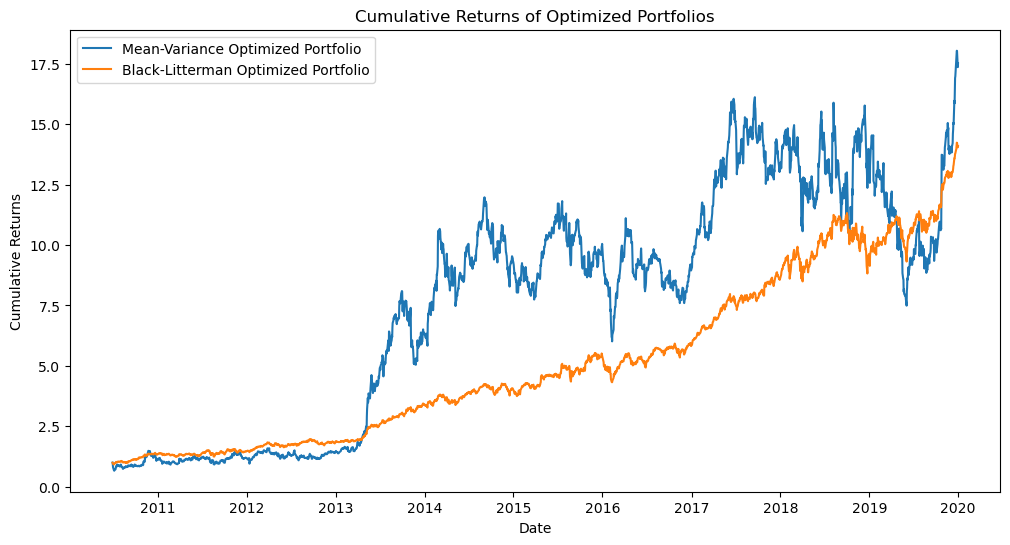

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(mean_variance_cumulative_returns, label='Mean-Variance Optimized Portfolio')
plt.plot(black_litterman_cumulative_returns, label='Black-Litterman Optimized Portfolio')
plt.title('Cumulative Returns of Optimized Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Mean-Variance Optimized Portfolio', 'Black-Litterman Optimized Portfolio'])
plt.show()